# Happy Customers
### Context:
We are one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. From operational standpoint we have been facing several different challenges and everyday we are trying to address these challenges.  

We thrive on making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.  

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.
We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.    

### Objective:  
1. Predict if a customer is happy or not based on the answers they give to questions asked.
2. Reach 73% F1 score or above.
3. Identify features most important when predicting a customer's happiness.
4. Discover minimal set of features what would preserve the most information about the problem while increasing predictabiliy of the data.

### Dataset: 
- Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers   
- X1 = my order was delivered on time  
- X2 = contents of my order was as I expected  
- X3 = I ordered everything I wanted to order  
- X4 = I paid a good price for my order  
- X5 = I am satisfied with my courier  
- X6 = the app makes ordering easy for me    

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.  

### Load Dataset and perform Exploratory Data Analysis:  

In [1]:
# import necessary libraries for modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Load csv dataset
customer_survey_filepath = '../data/raw/ACME-HappinessSurvey2020.csv'
#customer_survey_filepath = 'ACME-HappinessSurvey2020.csv'
customer_survey = pd.read_csv(customer_survey_filepath)

# Rename column names for better interpretability
customer_survey.rename(columns = {
    'Y':'Target',
    'X1':'Delivered_On_Time',
    'X2':'Contents_As_Expected',
    'X3':'Everything_Wanted_Ordered',
    'X4':'Good_Price',
    'X5':'Satisfied_With_Courier',
    'X6':'Ordering_Ease'
},inplace=True)
customer_survey.head()
customer_survey.to_csv('../data/interim/renamed_customer_survey.csv', index=False)


In [2]:
customer_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Target                     126 non-null    int64
 1   Delivered_On_Time          126 non-null    int64
 2   Contents_As_Expected       126 non-null    int64
 3   Everything_Wanted_Ordered  126 non-null    int64
 4   Good_Price                 126 non-null    int64
 5   Satisfied_With_Courier     126 non-null    int64
 6   Ordering_Ease              126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


**Observations:**
- There are no missing values in the dataset. 
- The dataset contains 126 rows with 7 columns. 

In [11]:
customer_survey.describe().T

,count,mean,std,min,25%,50%,75%,max
Target,126.0,0.547619,0.499714,0.0,0.0,1.0,1.0,1.0
Delivered_On_Time,126.0,4.333333,0.800000,1.0,4.0,5.0,5.0,5.0
Contents_As_Expected,126.0,2.531746,1.114892,1.0,2.0,3.0,3.0,5.0
Everything_Wanted_Ordered,126.0,3.309524,1.023440,1.0,3.0,3.0,4.0,5.0
Good_Price,126.0,3.746032,0.875776,1.0,3.0,4.0,4.0,5.0
Satisfied_With_Courier,126.0,3.650794,1.147641,1.0,3.0,4.0,4.0,5.0
Ordering_Ease,126.0,4.253968,0.809311,1.0,4.0,4.0,5.0,5.0


**Summary Statistics:**  
- The target attribute's mean was 55%, a slightly higher proportion of happy customers. 
- Nearly all features have a mean above 3/5, indicating a general outlook of positive feedback.
- **Contents_As_Expected(X2)** has the lowest mean, implies this feature might contribute the most to customer dissatisfication with the app.  
- **Ordering_Ease(X6)** and **Delivered_On_Time(X1)** has the highest means above 4 points, suggesting customers had high satisfication with  
  how fast the order was delivered and the ease of using the app to order.


#### Barplots of the target variable and features:  

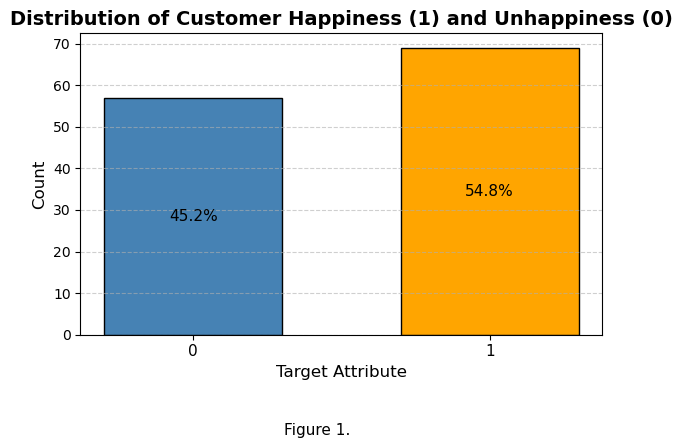

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_target_distribution(data, target_col, title, figure_label: str = 'Figure 1.'):
    """
    Plots a bar chart showing the distribution of a binary target variable,
    with percentage labels displayed inside each bar.
    
    Parameters:
        data (pd.DataFrame): The input DataFrame.
        target_col (str): The name of the binary target column.
        title (str): The title of the plot.
        figure_label (str): A label displayed beneath the figure.
    """
    # Compute value counts and percentages
    value_counts = data[target_col].value_counts().sort_index()
    total = value_counts.sum()
    percentages = (value_counts / total * 100).round(1)

    # Set up plot
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(
        value_counts.index.astype(str), 
        value_counts.values, 
        color=['steelblue', 'orange'],
        edgecolor='black',
        width=0.6
    )

    # Add percentage labels inside bars
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height * 0.5,  # Position text at 50% of bar height
            f"{pct}%", 
            ha='center', 
            va='center', 
            fontsize=11,
            color='black' if height > total * 0.15 else 'black'  # Adjust color for visibility
        )

    # Format axes and title
    ax.set_xlabel('Target Attribute', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index.astype(str), fontsize=11)

    # Add figure label
    fig.text(0.5, -0.1, figure_label, fontsize=11, ha='center')

    plt.tight_layout()
    plt.show()

# Example usage
plot_target_distribution(
    data=customer_survey,
    target_col='Target',
    title='Distribution of Customer Happiness (1) and Unhappiness (0)'
)


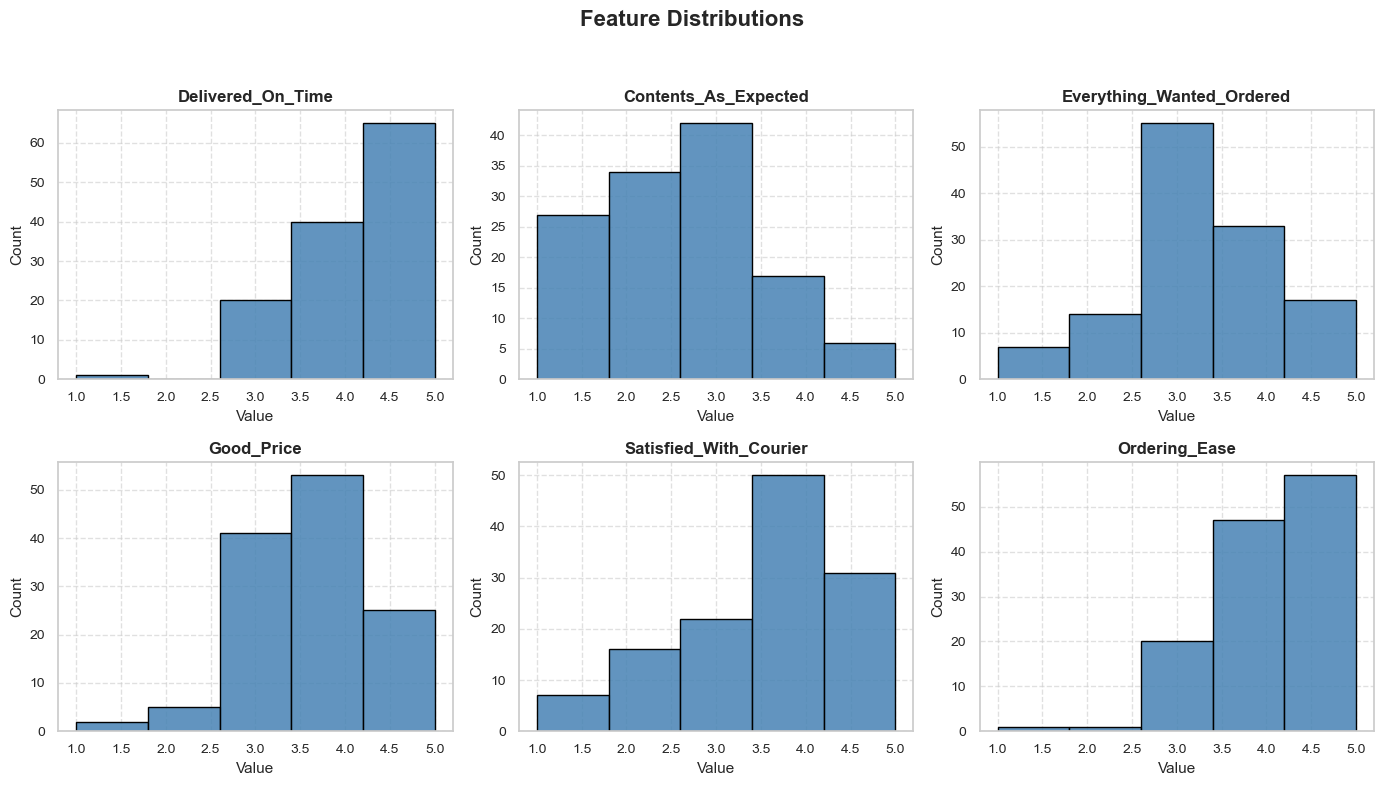

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_distributions(data: pd.DataFrame, features: list):
    """
    Plots histograms for a list of features from a DataFrame in a 2x3 grid layout.
    
    Parameters:
        data (pd.DataFrame): The input DataFrame.
        features (list): List of feature column names to plot.
    """
    # Set global style for consistent aesthetics
    sns.set(style='whitegrid', font_scale=1.0)
    plt.rcParams['axes.labelsize'] = 11
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10

    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
    axes = axes.flatten()

    # Plot histograms
    for i, column in enumerate(features):
        ax = axes[i]
        sns.histplot(
            data[column],
            bins=5,
            kde=False,
            color='steelblue',
            edgecolor='black',
            alpha=0.85,
            ax=ax
        )
        ax.set_title(column, fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Count')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused axes if fewer than 6 features
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

    # Title and layout adjustments
    fig.suptitle('Feature Distributions', fontsize=16, fontweight='bold')
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    plt.show()

# Example usage
plot_feature_distributions(
    data=customer_survey,
    features=customer_survey.columns[1:].tolist()  # Assuming the first column is the target
)


**Visualization Observations:**
- From **Figure 1** and the summary statistic, 45% of the customer base are unsatisfied with the business model. This is an unsustainable strategy, and issues  
must be addressed to solve this disatissfication.  
- **Figure 2** illustrates, *Everything_Wanted_Order* and *Contents_As_Expected* features are slightly right skewed with scores normally distributed   
around a lesser score of 3 compared to other features. Other features' barplots are left skewed.  

### Correlation Heatmap:  

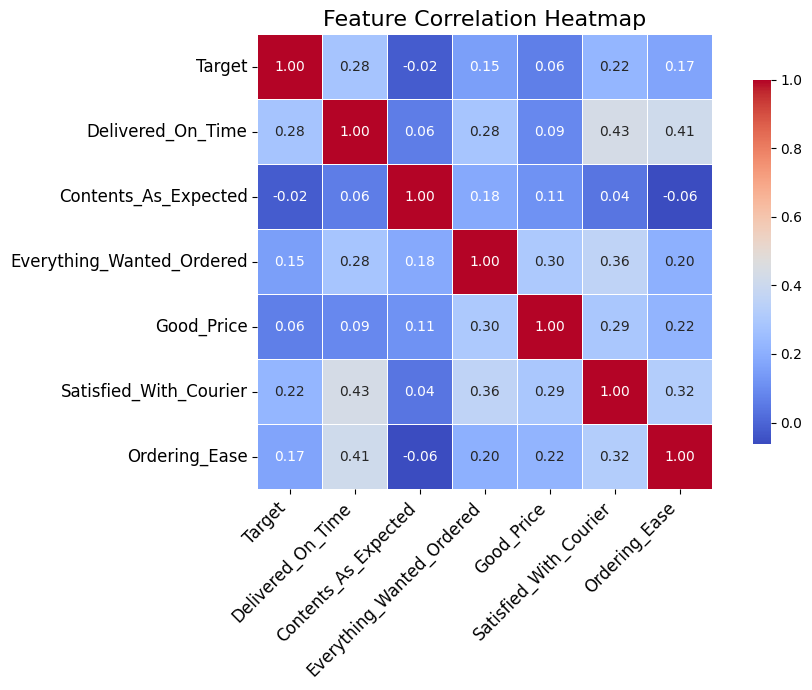

In [4]:
import seaborn as sns

correlation_matrix = customer_survey.corr()

# Plotting correlation heatmap
fig, ax = plt.subplots(figsize=(10,7))

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidth=0.5,
    square=True, # heatmap cells are square
    cbar_kws={'shrink':0.8},
    ax=ax
)
# Set Title
ax.set_title('Feature Correlation Heatmap', fontsize=16)
# Tick label formatting, rotate x-axis label for better visibility
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)

# Adjust layout to prevent clipping
fig.tight_layout()
# Show the plot
plt.show()

**Correlation Analysis:**  
- Features *Delivered_on_Time* and *Satisfied_With_Courier* have the highest correlation with how happy and unhappy customers are with the business product  
  at 0.28 and 0.22 respectively. *Ordering_Ease* and *Everything_Wanted_Ordered* follows up as having the next highest correlation with 0.17 and 0.15 respectively.  
- Features *Contents_As_Expected* and *Good_Price* have a weak correlation possible indicating that order expectations and price do not heavily influence  
  customer happiness.  
- Several features have high correlations with each other which may affect our classification model performance. An example is *Delivered_On_Time* and *Satisfied_With_Courier*  
  having a correlation of 0.43 since the customer would either be satisfied/disatisfied with the courier if the order was delivered on or not on time.

### Feature Selection:  
A Feature selection approach before model selecton is performed to improve classification model performance, reduce overfitting and to enhance interpretability. To determine the minimal set of  
features necessary to perserve the most information while maximizing predictability, a combination approach of statistical tests, model-based feature selection and correlation-based analysis  
will be most effective.  

**Action Plan:**  
Statisical tests will involve computing mutual information to determine how much information one variable provides about another variable and ANOVA F-Test. ANOVA F-test is used to determine if  
statistically significant differences exist between the means of two or more groups. These tests will assess whether a feature is useful in predicting the target variable. Lasso Regression (L1 Regularization)  
will be used to shrink irrelevant features to zero and Random Forest will be utilized to validate which of the features drive the prediction. Features that are highly correlated, one of the two will be removed  
to prevent redunancy.  

In [43]:
# import necessary libraries for feature selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(42)

# Split features from target variable
features = customer_survey.drop(columns=['Target'])
target_variable = customer_survey['Target']

# Splitting Dataset
X_train, X_test, y_train, y_test = train_test_split(features, target_variable, test_size=0.15, random_state=42)
X_train.to_csv('../data/processed/final_x_train.csv', index=False)
y_train.to_csv('../data/processed/final_y_train.csv', index=False)
X_test.to_csv('../data/processed/final_x_test.csv', index=False)
y_test.to_csv('../data/processed/final_y_test.csv', index=False)

# Standardize training features for Lasso
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# --- Feature Selection on Training Data ---

# Mutual Information
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)

# ANOVA F-Test
anova_f_values, _ = f_classif(X_train, y_train)
anova_df = pd.DataFrame({
    'Feature': X_train.columns,
    'ANOVA F-Score': anova_f_values
}).sort_values(by='ANOVA F-Score', ascending=False)

# Lasso Logistic Regression (L1 Regularization)
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.2, random_state=42)
lasso.fit(X_train_scaled, y_train)
lasso_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Lasso Coefficients': lasso.coef_[0]
}).sort_values(by='Lasso Coefficients', key=abs, ascending=False)

# Random Forest Importance
rf = RandomForestClassifier(n_estimators=100, random_state=50)
rf.fit(X_train, y_train)
rf_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Random Forest Importance': rf.feature_importances_
}).sort_values(by='Random Forest Importance', ascending=False)

# Combine feature selection results
combined_df = mi_df.merge(anova_df, on='Feature')\
                   .merge(lasso_df, on='Feature')\
                   .merge(rf_df, on='Feature')

combined_df.sort_values(by='Random Forest Importance', ascending=False)
combined_df

,Feature,Mutual Information,ANOVA F-Score,Lasso Coefficients,Random Forest Importance
0,Satisfied_With_Courier,0.052792,3.731204,0.017994,0.175574
1,Delivered_On_Time,0.023862,10.608117,0.422726,0.162642
2,Contents_As_Expected,0.000000,0.791322,0.000000,0.184724
3,Everything_Wanted_Ordered,0.000000,1.217194,0.000000,0.188208
4,Good_Price,0.000000,0.000953,0.000000,0.149172
5,Ordering_Ease,0.000000,3.515792,0.019698,0.139680


**Feature Selection Findings:**  
**Mutual Information Values:**  
Mutual Information measures how much information a feature contributes to predicting our target variable (customer happiness). From the values shown in the table features **Delivered_On_Time** and **Satisfied_With_Courier** show relevant high MI values. The rest of the features show zero or near zero MI values, suggesting they contribute little unique information.  

**ANOVA F-Score:**  
The ANOVA F-Score measures the variance of the target variable explained by each feature. **Delivered_On_Time** and **Satisfied_With_Courier** explain the most variance in customer happiness with their high F-scores. **Contents_As_Expected** feature has the lowest F-score, implying it does not significantly differentiate between happy and unhappy customers.  

**Lasso Regression Coefficients:**  
Lasso Regression shrinks less important feature coefficients to 0, for feature removal selection. **Delivered_On_Time** has the highest value, confirming that this feature is strongly associated with our target variable followed by **Satisfied_With_Courier**. All the other feature's coefficient values have shrunk to 0, implying that Lasso does not consider these features important for prediction.  

**Random_Forest:**  
Random Forest Feature Importance measures the contribution of each feature in reducing predicting erros in a Random Forest model. In contrast to the previous three methods, this method values **Contents_As_Expected** and **Everything_Wanted_Ordered** over other features for tree based models.  

**Actionable Insights:**  
This approach shows that the strongest features are **Delivered_On_Time** and **Satisfied_With_Courier** in this dataset. Building a model with those two features and one additional feature such as **Ordering_Ease** can be the minimal amount of a feature set for prediction. The values also relay that removing **Contents_As_Expected** and **Everything_Wanted_Ordered** may have minimal impact for prediction and should be removed for future surveys if removal of questions is a priority in the next survey.  

### Model Building:  
The following classification models will be used to predict of a customer is happy or unhappy based on the answers they have given to the questions using our the these selected features:
- Selected Features : **Delivered_On_Time (X1)**, **Satisfied_With_Courier (X5)**, **Everything_Wanted_Ordered (X3)**, and **Ordering_Ease(X6)**.
- Training Set (80%), and Test Set(20%) to account for small dataset.
- Logistic Regression (Simple linear classifier)
- Decision Tree (tree-based classifier)
- Random Forest (ensemble of decision trees)
- Support Vector Machine (finds optimal hyperplane for separation)
- Naive Bayes (Bayes Theorem probabilistic classifer)

In [44]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import pandas as pd


def evaluate_models_with_cv(X_train, y_train, random_seed=42):
    """
    Trains 5 different classification models.
    Evaluates them using 5-fold cross-validation only on selected features.
    Computes Accuracy, Precision, Recall, and F1-Score.
    Returns a sorted DataFrame of averaged results.
    """
    # Subset the training data to the selected features
    selected_features = ['Delivered_On_Time', 'Satisfied_With_Courier', 'Everything_Wanted_Ordered', 'Ordering_Ease']
    X_train_selected = X_train[selected_features]

    # Define a dictionary of models to evaluate, using consistent random_state where applicable
    models = {
        'Logistic Regression': LogisticRegression(random_state=random_seed),
        'Decision Tree': DecisionTreeClassifier(random_state=random_seed),
        'Random Forest': RandomForestClassifier(random_state=random_seed),
        'Support Vector Machine': SVC(),
        'Naive Bayes': GaussianNB()
    }

    # Cross-validation strategy, a 5-fold stratified cv to maintain class balance across folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

    # Container to hold evaluation results for each model
    cv_results = []
    # Loop through each model to perform cross-validation
    for name, model in models.items():
        # F1-Score (harmonic mean of precision and recall)
        f1_scores = cross_val_score(model, X_train_selected, y_train, cv=cv, scoring='f1')
        accuracy_scores = cross_val_score(model, X_train_selected, y_train, cv=cv, scoring='accuracy')
        # Precision (True Positives / Predicted Positives)
        precision_scores = cross_val_score(model, X_train_selected, y_train, cv=cv, scoring='precision')
        # Recall (True Positives / actual positives)
        recall_scores = cross_val_score(model, X_train_selected, y_train, cv=cv, scoring='recall')
        # Store mean of each metric for the current iteration of model
        cv_results.append({
            'Model': name,
            'CV Accuracy': accuracy_scores.mean(),
            'CV Precision': precision_scores.mean(),
            'CV Recall': recall_scores.mean(),
            'CV F1-Score': f1_scores.mean()
        })

    # Convert to DataFrame and sort by F1-Score
    cv_metrics_df = pd.DataFrame(cv_results).sort_values(by='CV F1-Score', ascending=False)

    print("Cross-Validation Performance Summary:")
    from IPython.display import display
    display(cv_metrics_df)

    return cv_metrics_df

initial_models = evaluate_models_with_cv(X_train, y_train)

Cross-Validation Performance Summary:


,Model,CV Accuracy,CV Precision,CV Recall,CV F1-Score
2,Random Forest,0.645455,0.661477,0.766667,0.701509
3,Support Vector Machine,0.553247,0.568627,0.800000,0.664433
0,Logistic Regression,0.608658,0.647067,0.700000,0.658583
1,Decision Tree,0.579654,0.642787,0.633333,0.626842
4,Naive Bayes,0.552381,0.590079,0.666667,0.614799


### Hyperparameter Tuning on all models using GridSearchCV:   
As F1 scores for each of the models aside from Random Forest are less than ideal (less than 73%), GridSearchCV will be utilized to tune each model's hyperparameters to improve their performance. Naive Bayes does not have tunable parameters, so it will GridSearchCV will not be performed on the model. Grid Search involves forming a grid that is the Cartesian product of those parameters and then sequentially trying all combinations and returning the best parameters that give the best scoring metric. Grid Search is ideal as this is a small dataset and there is a small number of hyperparameters.   

In [45]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd


def tune_and_evaluate_models(x_train, y_train, x_test, y_test, random_seed=42):
    # Subset training and testing data with only selected features
    selected_features = ['Delivered_On_Time', 'Satisfied_With_Courier', 'Everything_Wanted_Ordered', 'Ordering_Ease']
    x_train = x_train[selected_features]
    x_test = x_test[selected_features]

    # Define 5-fold cross-validation strategy with stratification
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

    # Define hyperparameter grids for GridSearchCV for each model (where applicable)
    param_grids = {
        'Logistic Regression': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l2'],
            'clf__solver': ['liblinear']
        },
        'Decision Tree': {
            'clf__max_depth': [3, 5, 10, None],
            'clf__min_samples_split': [2, 5, 10],
            'clf__min_samples_leaf': [1, 2, 4]
        },
        'Random Forest': {
            'clf__n_estimators': [50, 100, 150, 200],
            'clf__max_depth': [None, 3, 5, 10],
            'clf__min_samples_split': [2, 5],
            'clf__min_samples_leaf': [1, 2],
            'clf__max_features': ['sqrt'],
            'clf__bootstrap': [True]
        },
        'Support Vector Machine': {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf'],
            'clf__gamma': ['scale', 'auto']
        }
    }

    # Define pipelines for each model (with scaling where required)
    model_defs = {
        'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(random_state=random_seed))]),
        'Decision Tree': Pipeline([('clf', DecisionTreeClassifier(random_state=random_seed))]),
        'Random Forest': Pipeline([('clf', RandomForestClassifier(random_state=random_seed))]),
        'Support Vector Machine': Pipeline([('scaler', StandardScaler()), ('clf', SVC())]),
        'Naive Bayes': Pipeline([('clf', GaussianNB())])  # No hyperparameter tuning needed
    }

    test_results = []

    # Loop through each model and perform tuning or direct training
    for name, pipeline in model_defs.items():
        print(f"Tuning: {name}")

        if name in param_grids:
            # Use GridSearchCV to find the best hyperparameters using 5-fold CV on training data
            grid = GridSearchCV(pipeline, param_grids[name], scoring='f1', cv=cv_strategy, n_jobs=-1)
            grid.fit(x_train, y_train)
            best_model = grid.best_estimator_  # Model trained on full training data with best hyperparameters
            best_params = grid.best_params_
        else:
            # No tuning for Naive Bayes, directly fit the model
            pipeline.fit(x_train, y_train)
            best_model = pipeline
            best_params = 'None'

        # Make predictions on the holdout test set
        y_test_pred = best_model.predict(x_test)

        # Generate classification metrics
        report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)

        # Store evaluation results for the model
        test_results.append({
            'Model': name,
            'Best Params': best_params,
            'Accuracy': accuracy_score(y_test, y_test_pred),
            'Precision': report['1']['precision'],
            'Recall': report['1']['recall'],
            'F1-Score': report['1']['f1-score']
        })

    # Compile all results into a DataFrame sorted by F1-Score
    tuned_metrics_df = pd.DataFrame(test_results).sort_values(by='F1-Score', ascending=False)

    print("\nTest Set Performance")
    from IPython.display import display
    display(tuned_metrics_df)

    return tuned_metrics_df

final_tuned_models = tune_and_evaluate_models(X_train, y_train, X_test, y_test)

Tuning: Logistic Regression
Tuning: Decision Tree
Tuning: Random Forest
Tuning: Support Vector Machine
Tuning: Naive Bayes

Test Set Performance


,Model,Best Params,Accuracy,Precision,Recall,F1-Score
2,Random Forest,"{'clf__bootstrap': True, 'clf__max_depth': 10,...",0.789474,0.727273,0.888889,0.800000
3,Support Vector Machine,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.473684,0.473684,1.000000,0.642857
1,Decision Tree,"{'clf__max_depth': 3, 'clf__min_samples_leaf':...",0.526316,0.500000,0.888889,0.640000
0,Logistic Regression,"{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__so...",0.473684,0.461538,0.666667,0.545455
4,Naive Bayes,None,0.473684,0.461538,0.666667,0.545455


In [50]:
# Rename columns to distinguish scores
initial = initial_models[['Model', 'CV F1-Score']].rename(columns={'CV F1-Score': 'F1-Score_Untuned'})
tuned = final_tuned_models[['Model', 'F1-Score']].rename(columns={'F1-Score': 'F1-Score_Tuned'})

# Merge and sort
combined_f1_scores = initial.merge(tuned, on='Model')
combined_f1_scores = combined_f1_scores.sort_values(by='F1-Score_Tuned', ascending=False)
combined_f1_scores


,Model,F1-Score_Untuned,F1-Score_Tuned
0,Random Forest,0.701509,0.800000
1,Support Vector Machine,0.664433,0.642857
3,Decision Tree,0.626842,0.640000
2,Logistic Regression,0.658583,0.545455
4,Naive Bayes,0.614799,0.545455


**Results:**  
Hyperparameter tuning all our models besides Naive Bayes results in Random Forest having the highest F1-Score of 82% which surpasses our objective of reaching an F1-Score of 73% or more. The precision of the tuned Random Forest is 75% and the recall is 90%. The tuned hyperparameters for the Random Forest are as follows: bootstrap:False, max_depth:5, max_features:sqrt, min_samples_leaf:2, min_samples_split:5, and n_estimators:150. 

**Conclusion:**  
Among the various classification models evaluated, the **Random Forest model** demonstrated the highest perforamnce, achieving an **accuracy of 78%** and an **F1-Score of 81.78%**.  

Through exploratory data analysis (EDA) and feature selection, the most influential features for predicting customer happiness were identified as follows: X1 (my order was delivered on time), X3 (I received everything I ordered), X5 (I am satisfied with my courier), and X6 (the app makes ordering easy for me). Among these, X5 and X1 emerged as the strongest features in terms of predictive power. These four features form the minimal set that retains the most predictive information about customer satisfaction. Reducing the feature set further results in a noticeable drop in model performance.  

Based on their limited contribution to prediction accuracy, the company may consider removing the following questions from the survey: X2 (the contents of my order were as I expected) and X4 (I paid a good price). These variables showed low predictive power in determining overall customer happiness.